## Map the Cell Type Data to the UMAP data

This allows for comparing cell types to unassigned genes

In [1]:
# Check the version of anndata we are using
import anndata as ad
import pandas as pd
ad.__version__

'0.8.0'

In [2]:
# Load the h5ad file
ad_worm_aging = ad.read("input_data/ad_worm_aging.h5ad")
ad_worm_aging

AnnData object with n_obs × n_vars = 47423 × 20305
    obs: 'n_counts', 'n_genes', 'timepoint', 'annotate_name'
    var: 'gene_ids', 'gene_names', 'gene_class', 'n_counts', 'n_cells'
    uns: 'timepoint_colors'
    obsm: 'X_umap', 'scvi'
    layers: 'denoised'

In [3]:
# Load observations into it own variable
# OBSERVED OUTPUT: obs contains: 'n_counts', 'n_genes', 'timepoint', 'annotate_name'
obs_df = ad_worm_aging.obs
obs_df

,n_counts,n_genes,timepoint,annotate_name
TCTTGCGAGTCCTGCG-1-TC2_d11_1,53587.0,619,d11,41_2:marginal cells
GCTACAAGTGTGGTCC-1-TC2_d11_1,52800.0,253,d11,41_1:NA pharyngeal epithelium
TGGGAAGTCGGCTTGG-1-TC2_d11_1,43280.0,1459,d11,41_2:marginal cells
AAGTGAACAACCGACC-1-TC2_d11_1,31445.0,1140,d11,41_1:NA pharyngeal epithelium
GTAGCTAAGCTACGTT-1-TC2_d11_1,30088.0,1476,d11,78_0:pharyngeal gland cell
...,...,...,...,...
TCAGGTACAGACAATA-1-TC2_d8_2,283.0,190,d8,34_1:PH socket
CTGTAGACATTGCTGA-1-TC2_d8_2,315.0,221,d8,52_0:RMD motor neurons
CGTGATAGTACACTCA-1-TC2_d8_2,271.0,183,d8,3_0:germline
GTTCATTAGCGCCATC-1-TC2_d8_2,261.0,134,d8,7_0:vulval muscle


In [4]:

obs_df['timepoint'].value_counts()

d3     13745
d1     12336
d8     10442
d5      6098
d11     4583
d15      219
Name: timepoint, dtype: int64

In [5]:
# Create a category type list 
# for categories you can use the full cell type name or a partial name to collect common cell types
def tissue_type_cat(row):
    categories = ['neuron','glia','muscle','hypodermis','seam','epithelium','coelomocyte',
                  'intestine','gland','germline','mesoderm','valve','gonad','pharyngeal']
    ret_val='other'
    for cat in categories:
        if cat in row['annotate_name']:
            ret_val=cat
            break
    return ret_val

# Add category column to obs_df
obs_df['category'] = obs_df.apply(lambda row: tissue_type_cat(row), axis=1)


In [6]:
## Print the color palate for TABLEAU_COLORS
#import matplotlib.colors as mcolors
#print(mcolors.TABLEAU_COLORS)

In [7]:
# Map the categories from above to the UMAP 
X_umap = ad_worm_aging.obsm['X_umap']
X_umap_df = pd.DataFrame(X_umap, columns = ['X','Y'])

# Add the category to the X_umap_df
obs_df.reset_index(drop=True, inplace=True)
X_umap_df = X_umap_df.join(obs_df['category'])
print(X_umap_df) 

               X          Y    category
0      11.996049  -4.528540       other
1      11.966536  -4.563943  epithelium
2      12.137930  -4.606019       other
3      12.171188  -4.609626  epithelium
4       1.208974  -5.466276       gland
...          ...        ...         ...
47418   6.838445  -4.121013       other
47419  13.993632  10.459724      neuron
47420   8.334566  -3.902491    germline
47421  14.051341  -5.063011      muscle
47422   2.027979 -14.025132      neuron

[47423 rows x 3 columns]


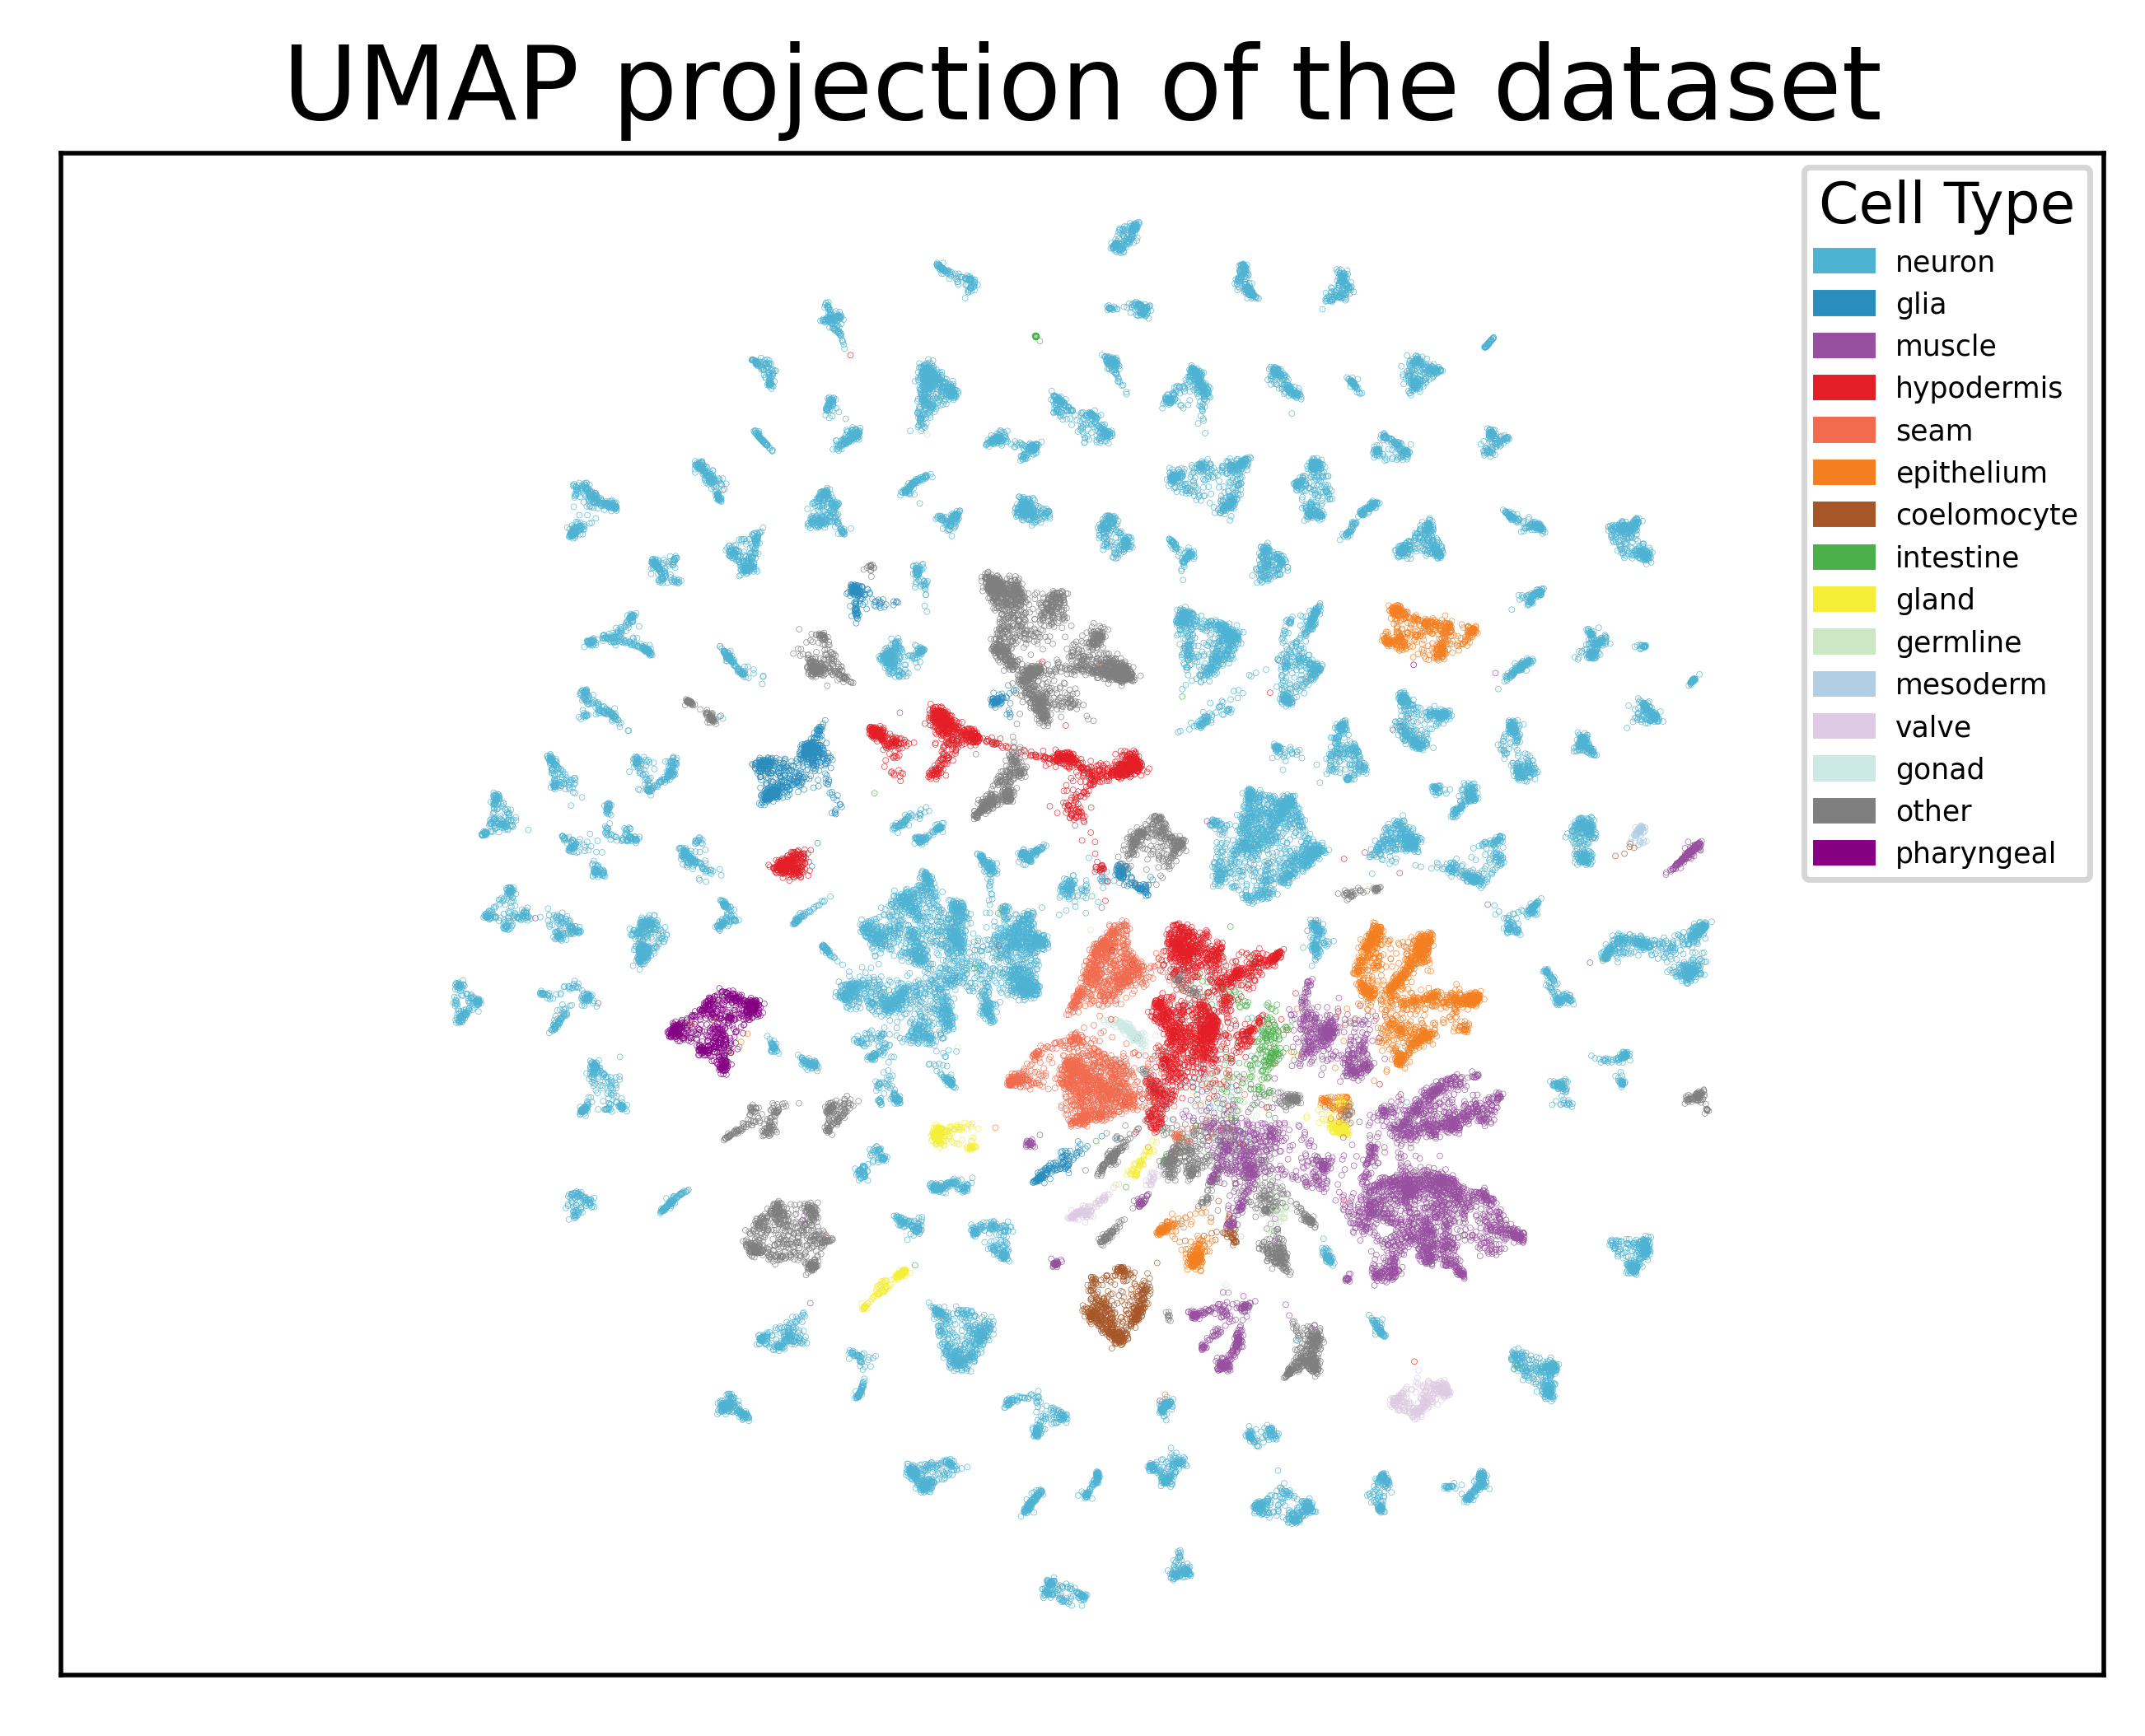

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as np
%matplotlib inline

# Create a color map
colors = {'neuron':'#4eb3d3','glia':'#298dbe','muscle':'#97509f','hypodermis':'#e41e26','seam':'#f16b4e',
          'epithelium':'#f47f20','coelomocyte':'#a65728','intestine':'#4bb049','gland':'#f5ee39','germline':'#cde7c4',
          'mesoderm':'#b2cee4','valve':'#decbe3','gonad':'#cde9e4','other':'#7f7f7f','pharyngeal':'#860084'}


plt.rcParams['figure.dpi'] = 500
sss = plt.scatter(X_umap_df['X'],X_umap_df['Y'], c=X_umap_df['category'].map(colors), s=.008)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=18);
plt.yticks([])
plt.xticks([])

patches = [ mpatches.Patch(color=colors[key], label=key) for key in colors.keys()]
plt.rcParams["legend.fontsize"] = 5
legend = plt.legend(handles=patches)
legend.set_title('Cell Type')

file_name='./output_data/umap_top_15_cell_categories.png'
plt.savefig(file_name)

In [9]:
%%bash

# Replace file name with the name of file to be resized
file_nm='umap_top_15_cell_categories.png'
pic_size=`identify -format "%[fx:w]x%[fx:h]" ${file_nm}`

if [[ "${pic_size}" == "3200x2400" ]]; then
    echo image ${pic_size} resized
    convert ${file_nm} -resize 40% tmp_${file_nm}
    mv tmp_${file_nm} ${file_nm}
else
    echo image already resized ${pic_size}
fi

identify: unable to open image 'umap_top_15_cell_categories.png': No such file or directory @ error/blob.c/OpenBlob/3569.


image already resized


In [ ]:
# # Trying an alternative way to draw the scatter plot
# # Create a color map
# colors = {'other':'#7f7f7f', 'neuron':'#1f77b4', 'muscle':'#9467bd', 'hypodermis':'#d62728'}

# fig, ax = plt.subplots()
# grouped = X_umap_df.groupby('category')
# for key, group in grouped:
#     group.plot(ax=ax, kind='scatter', x='X', y='Y', s=.008, label=key, color=colors[key])
# plt.show()